In [1]:
import pandas as pd
import datetime

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
sns.set(style='whitegrid', color_codes=True)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
df = pd.read_pickle('indego_df_model.pkl')
df.head(3)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,plan_duration,trip_route_category,passholder_type,duration_type,distance,start_weekday,start_hour,start_date,isBday,start_month
0,25183529,4.0,2016-07-01 00:07:00,2016-07-01 00:11:00,3063,39.946331,-75.169800,3064,39.938400,-75.173271,...,30,One Way,Indego30,very short,0.930208,Friday,0,2016-07-01,1.0,7
1,25183528,8.0,2016-07-01 00:10:00,2016-07-01 00:18:00,3124,39.952950,-75.139793,3026,39.941380,-75.145638,...,30,One Way,Indego30,very short,1.379643,Friday,0,2016-07-01,1.0,7
2,25183527,17.0,2016-07-01 00:11:00,2016-07-01 00:28:00,3043,39.930820,-75.174744,3034,39.933151,-75.162483,...,30,One Way,Indego30,short,1.077087,Friday,0,2016-07-01,1.0,7


# 1. Calculate total trip according to day/hour

In [4]:
df_trip = df.groupby(['start_weekday', 'start_hour']).count().trip_id.reset_index().copy()
df_trip.columns = ['Day of the Week', 'Hour', 'trips']
df_trip.head(3); df_trip.dtypes

,Day of the Week,Hour,trips
0,Sunday,0,4529
1,Sunday,1,3573
2,Sunday,2,2835


Day of the Week    category
Hour                  int64
trips                 int64
dtype: object

In [6]:
trip = df_trip.pivot('Day of the Week', 'Hour', 'trips')
trip.index = pd.CategoricalIndex(trip.index, categories= ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
trip.sort_index(level=0, inplace=True)

### Plot total trip's day/hour heatmap

<IPython.core.display.Javascript object>


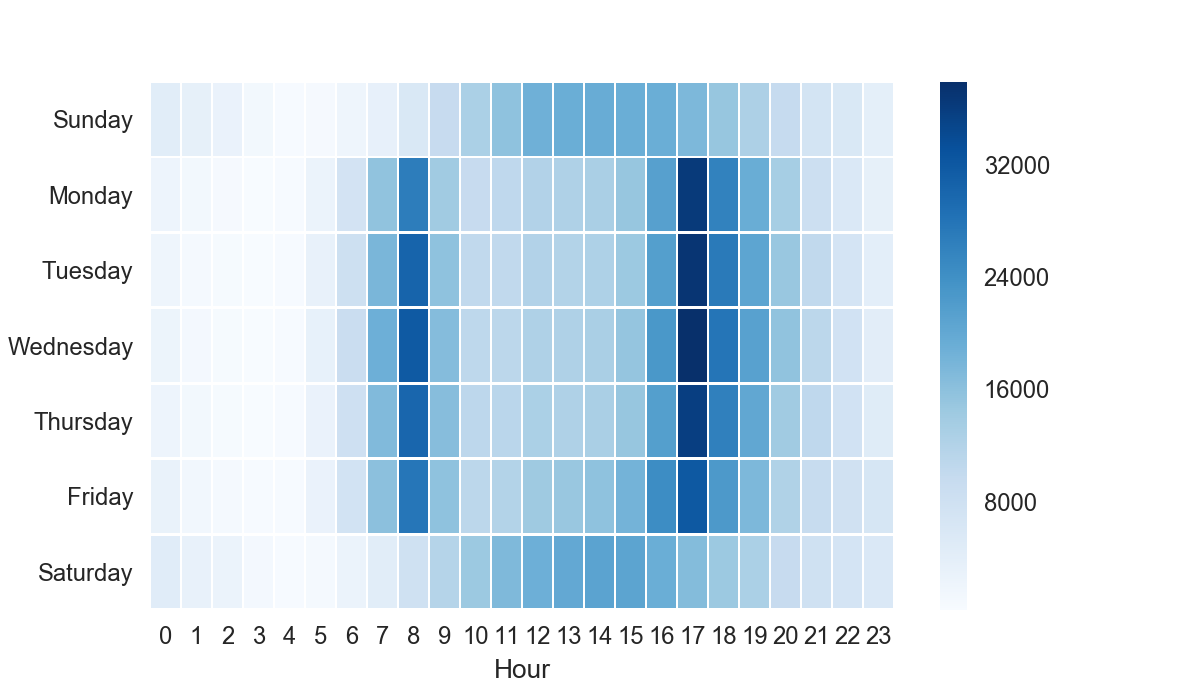

In [10]:
f1, ax1 = plt.subplots(figsize=(7, 4))
sns.heatmap(trip,square=False, linewidths=.8, cmap='Blues')

### Plot total trip's month/hour heatmap

In [11]:
df['start_month'] = df.start_time.dt.month
df_trip_month = df.groupby(['start_month', 'start_hour']).count().trip_id.reset_index().copy()
df_trip_month.columns = ['Month', 'Hour', 'trips']
trip_month = df_trip_month.pivot('Month', 'Hour', 'trips')

<IPython.core.display.Javascript object>


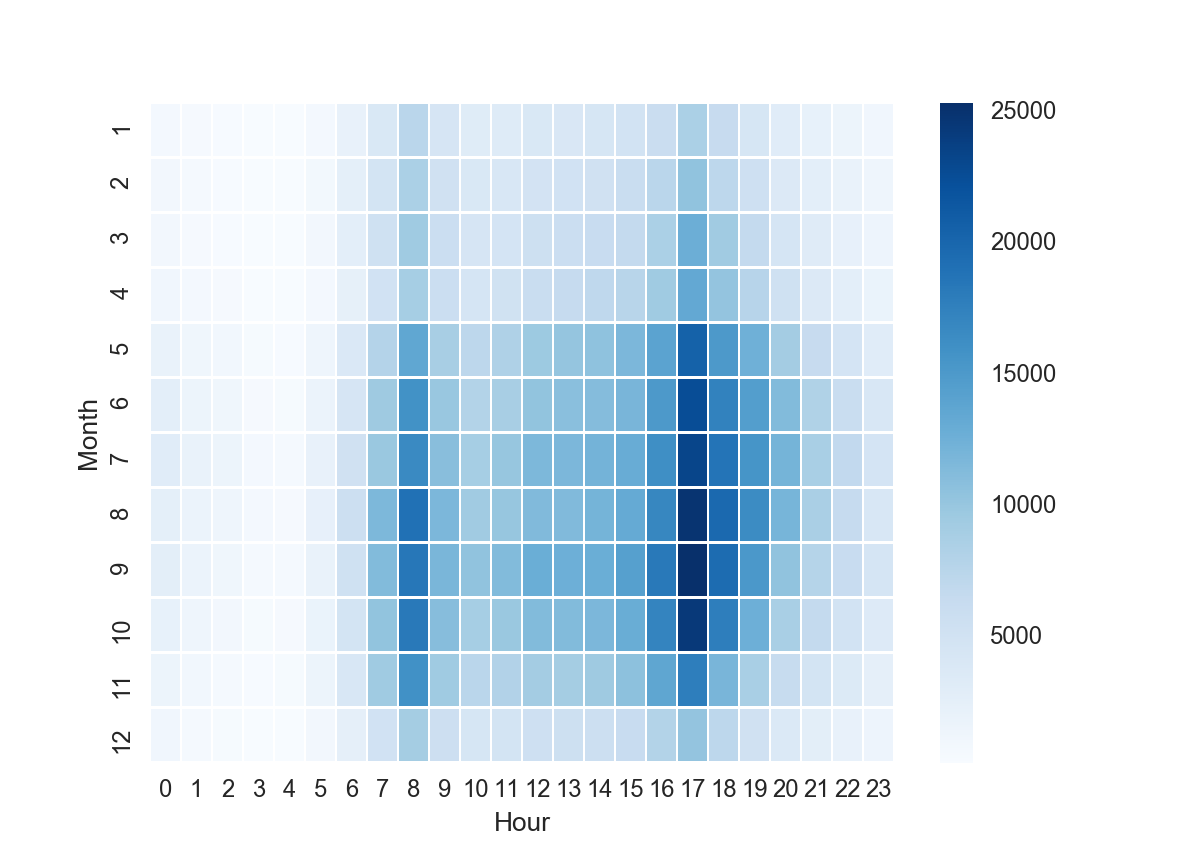

In [12]:
f2, ax2 = plt.subplots(figsize=(7, 5))
sns.heatmap(trip_month, square=False, linewidths=.8, cmap='Blues')

# 2. Calculate total trip according to day/hour

In [23]:
df.start_station.nunique(); df.bike_id.nunique()

127

1996

In [13]:
df_trip_start_station = df.groupby(['start_station', 'start_hour']).count().trip_id.reset_index().copy()
df_trip_start_station.columns = ['Start Station', 'Hour', 'trips']
df_trip_start_station['trips'].describe()

count     3017.000000
mean       648.120318
std        922.675915
min          1.000000
25%         80.000000
50%        277.000000
75%        893.000000
max      12534.000000
Name: trips, dtype: float64

In [14]:
df_trip_start_station.sort_values('trips', ascending=False, inplace=True)
df_trip_start_station.head(10)

,Start Station,Hour,trips
425,3021,17,12534
401,3020,17,8771
161,3010,17,7968
473,3023,17,7962
474,3023,18,6767
449,3022,17,6341
426,3021,18,6170
953,3045,17,6053
472,3023,16,5945
424,3021,16,5809


### Plot total trips according different station and hour

In [15]:
trip_start_station = df_trip_start_station.pivot('Start Station', 'Hour', 'trips')

<IPython.core.display.Javascript object>


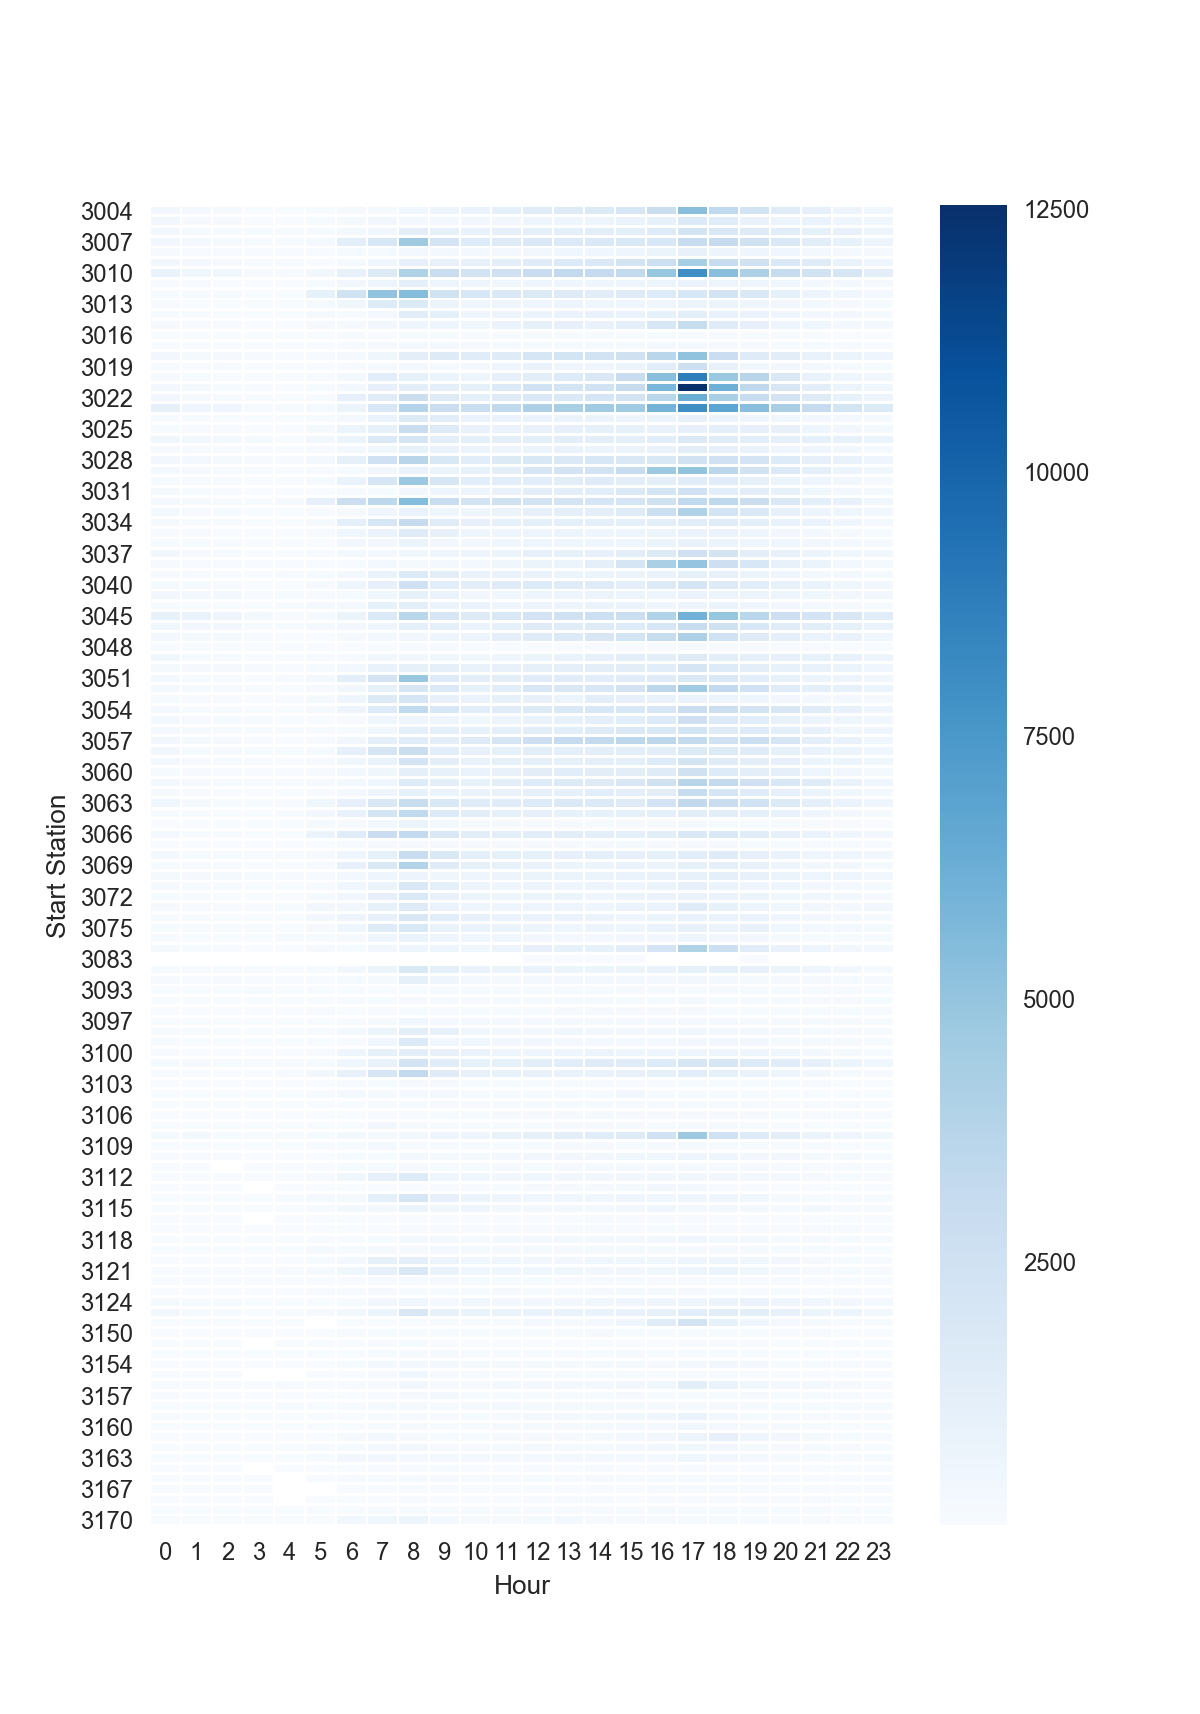

In [16]:
f3, ax3 = plt.subplots(figsize=(7, 10))
sns.heatmap(trip_start_station, square=False, linewidths=.8, cmap='Blues')

# 3. Resample time to quarters

In [17]:
df['start_time'].dt.quarter.head(1)==3; df['start_time'].head(1)

0    True
Name: start_time, dtype: bool

0   2016-07-01 00:07:00
Name: start_time, dtype: datetime64[ns]

In [20]:
df['quarter'] = df['start_time'].dt.to_period('Q').astype(str)

In [22]:
quarter_list = df['quarter'].unique().tolist()
quarter_list

['2016Q3',
 '2018Q1',
 '2017Q4',
 '2017Q1',
 '2016Q4',
 '2017Q3',
 '2016Q1',
 '2016Q2',
 '2017Q2',
 '2015Q4',
 '2015Q3',
 '2015Q2']

### Create csv files for all quarters for trip flow plots

In [112]:
for quarter in quarter_list:
    condi_quarter = (df['quarter']==quarter)
    df_quarter = df[condi_quarter].groupby(['start_station', 'end_station']).count().trip_id.reset_index().copy()
    df_quarter['start_station'] = df_quarter['start_station'].map(str).apply(lambda x: 'ph'+x)
    df_quarter['end_station'] = df_quarter['end_station'].map(str).apply(lambda x: 'ph'+x)
    pivot = df_quarter.pivot('start_station', 'end_station', 'trip_id')
    pivot.to_csv("{}-flow.csv".format(quarter))

In [87]:
df.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'duration_type', 'distance', 'start_weekday', 'start_hour',
       'start_month', 'quarter'],
      dtype='object')

In [113]:
df_station = df.groupby('start_station').mean()[['start_lat', 'start_lon']].reset_index().copy()
df_station['start_station'] = df_station['start_station'].map(str).apply(lambda x: 'ph'+x)
df_station.to_csv("station.csv", columns=['start_station','start_lon', 'start_lat'])

# 3. Identify bottlenecks 

In [115]:
station_address = pd.read_csv('indego-stations-2018-1-19.csv')

In [118]:
station_address[station_address['Station ID']==3021]

,Station ID,Station Name,Go live date,Status
18,3021,18th & JFK,4/23/2015,Active


### Read real-time monitoring json file from indego website

In [23]:
status = pd.read_json('https://gbfs.bcycle.com/bcycle_indego/station_status.json')

In [25]:
d1 = {s['station_id']:s['num_bikes_available'] for s in status['data']['stations']}
d2 = {s['station_id']:s['num_docks_available'] for s in status['data']['stations']}

In [26]:
df_status = pd.DataFrame([d1, d2]).T.reset_index()
df_status.columns=(['station', 'num_bikes_available', 'num_docks_available'])
df_status['station'] = df_status['station'].apply(lambda x: x.split('_')[-1])
df_status['station'] = df_status['station'].astype(int)
df_status['total_docks'] = df_status['num_bikes_available'] + df_status['num_docks_available']

In [27]:
df_status.sum(); df_status.head(3)

station                378652
num_bikes_available       977
num_docks_available      1369
total_docks              2346
dtype: int64

,station,num_bikes_available,num_docks_available,total_docks
0,3004,2,27,29
1,3005,13,0,13
2,3006,2,13,15


In [28]:
df.groupby(['start_station']).count().head(3)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,...,trip_route_category,passholder_type,duration_type,distance,start_weekday,start_hour,start_date,isBday,start_month,quarter
start_station,,,,,,,,,,,,,,,,,,,,,
3004,29007,29007,29007,29007,29007,29007,29007,29007,29007,29007,...,29007,29007,29007,29007,29007,29007,29007,29007,29007,29007
3005,13234,13234,13234,13234,13234,13234,13234,13234,13234,13234,...,13234,13234,13234,13234,13234,13234,13234,13234,13234,13234
3006,22527,22527,22527,22527,22527,22527,22527,22527,22527,22527,...,22527,22527,22527,22527,22527,22527,22527,22527,22527,22527


### Calculate bike inbound and outbound rates

In [29]:
df['start_time'].head(1).dt.weekday_name; df['start_time'].head(1)

0    Friday
Name: start_time, dtype: object

0   2016-07-01 00:07:00
Name: start_time, dtype: datetime64[ns]

In [30]:
datetime.datetime(2017, 8, 17).weekday()

3

In [31]:
df['start_time'].head(1) == datetime.datetime(2016, 7, 1, 0, 7)

0    True
Name: start_time, dtype: bool

In [32]:
time1 = datetime.datetime(2017, 8, 17, 17, 0)
time2 = datetime.datetime(2017, 8, 17, 18, 0)
condi_out = (df['start_time']<time2)&(df['start_time']>=time1)

In [33]:
outbound = df[condi_out].groupby(['start_station']).count().trip_id.reset_index().copy()
outbound.columns=['station', 'out_trip']
outbound.head(3); outbound.shape

,station,out_trip
0,3004,13
1,3005,2
2,3006,2


(93, 2)

In [34]:
condi_in = (df['end_time']<time2)&(df['end_time']>=time1)
inbound = df[condi_in].groupby(['end_station']).count().trip_id.reset_index().copy()
inbound.columns=['station', 'in_trip']
inbound.head(3); inbound.shape

,station,in_trip
0,3004,2
1,3005,3
2,3006,3


(95, 2)

### Calculate traffic at stations

In [36]:
traffic = pd.merge(outbound, inbound, how='outer', on='station')

In [37]:
traffic.fillna(0, inplace=True)

In [38]:
traffic.head(3); traffic.dtypes

,station,out_trip,in_trip
0,3004,13.0,2.0
1,3005,2.0,3.0
2,3006,2.0,3.0


station       int64
out_trip    float64
in_trip     float64
dtype: object

In [39]:
df_traffic = pd.merge(traffic, df_status[['station', 'total_docks']], how='left', on='station')
condi_overflow = df_traffic['out_trip']-df_traffic['in_trip']
df_traffic.dropna(axis=0, how='any', inplace=True)

In [40]:
df_traffic.head(3)

,station,out_trip,in_trip,total_docks
0,3004,13.0,2.0,29.0
1,3005,2.0,3.0,13.0
2,3006,2.0,3.0,15.0


In [41]:
df_traffic.sort_values('in_trip', ascending=False).head(10)

,station,out_trip,in_trip,total_docks
69,3102,2.0,12.0,25.0
80,3125,2.0,11.0,19.0
25,3032,1.0,11.0,17.0
53,3066,5.0,10.0,19.0
13,3020,15.0,10.0,35.0
5,3009,8.0,9.0,13.0
95,3058,0.0,9.0,10.0
67,3100,4.0,8.0,38.0
68,3101,6.0,8.0,18.0
75,3114,1.0,8.0,17.0


### Note: assuming 20% overhead for the docks compared with bikes

In [42]:
df_traffic['out_ratio'] = (df_traffic['out_trip']-df_traffic['in_trip'])/(df_traffic['total_docks']*0.8)

In [43]:
df_traffic.sort_values('out_ratio', ascending=False).head(10)

,station,out_trip,in_trip,total_docks,out_ratio
14,3021,30.0,3.0,34.0,0.992647
71,3108,16.0,1.0,19.0,0.986842
6,3010,14.0,5.0,19.0,0.592105
62,3078,9.0,1.0,18.0,0.555556
31,3038,9.0,2.0,18.0,0.486111
0,3004,13.0,2.0,29.0,0.474138
50,3062,5.0,0.0,15.0,0.416667
11,3018,11.0,5.0,18.0,0.416667
84,3156,10.0,3.0,21.0,0.416667
81,3129,6.0,0.0,19.0,0.394737


#### Station 3021 & 3108 have high outbound ratios

In [44]:
df_traffic['in_ratio'] = (df_traffic['total_docks']*0.2+df_traffic['out_trip']-df_traffic['in_trip'])/(df_traffic['total_docks'])

In [46]:
df_traffic.sort_values('in_ratio', ascending=True).head(10)

,station,out_trip,in_trip,total_docks,out_ratio,in_ratio
95,3058,0.0,9.0,10.0,-1.125000,-0.700000
25,3032,1.0,11.0,17.0,-0.735294,-0.388235
80,3125,2.0,11.0,19.0,-0.592105,-0.273684
75,3114,1.0,8.0,17.0,-0.514706,-0.211765
69,3102,2.0,12.0,25.0,-0.500000,-0.200000
21,3028,2.0,8.0,15.0,-0.500000,-0.200000
27,3034,1.0,6.0,13.0,-0.480769,-0.184615
97,3098,0.0,6.0,18.0,-0.416667,-0.133333
66,3099,3.0,8.0,16.0,-0.390625,-0.112500
18,3025,2.0,6.0,13.0,-0.384615,-0.107692


#### Some stations have very low inbound ratio, due to 20% overhead. They are probably fine.